## Imports, loading data and utility functions

Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

from tqdm import tqdm

In [ ]:
def load_data(path: str) -> list:
    """
    Loads all data from a given path.

    parameters:
    -- path: Path string

    return value:
    -- A list of pd.DataFrames
    """

    df_list = []

    for csv_file in os.listdir(path):
        df = pd.read_csv(data_path + csv_file, skiprows=5)
        df.name = csv_file
        df_list.append(df)

    return df_list


def set_dataframes_format(df_list: list) -> list:
    """
    Setting all DataFrames in df_list to have the following columns:
    'Time [sec]', 'ACC X', 'ACC Y', 'ACC Z'
    and fixing the index if necessary.

    parameters:
    -- df_list: a list of pd.DataFrames

    return value:
    -- A list of pd.DataFrames with the above columns
    """

    good_columns = ['Time [sec]', 'ACC X', 'ACC Y', 'ACC Z']

    for dataframe in df_list:
        columns_list = list(dataframe.columns)
        for _ in range(2):
            if columns_list != good_columns:
                if "Unnamed: 0" in columns_list:
                    dataframe.columns = dataframe.iloc[0]
                    dataframe.drop(index=[0], axis=0, inplace=True)
                else:
                    dataframe.columns = good_columns
                columns_list = list(dataframe.columns)

    for dataframe in df_list:  # Fix index
        if dataframe.index[0] != 0:
            dataframe.set_index([pd.RangeIndex(start=0, step=1, stop=dataframe.index.stop - 1)], inplace=True)

    return df_list


data_path = r'./data/'
dataframes = load_data(path=data_path)
dataframes = set_dataframes_format(dataframes)

In [ ]:
def plot_df(df: pd.DataFrame):
    """
    Plots 3 lines, for each acceleration axis, as a function of time.

    parameters:
    -- df: pd.DataFrame with walking/running data
    """

    plt.plot(df['Time [sec]'], df['ACC X'])
    plt.plot(df['Time [sec]'], df['ACC Y'])
    plt.plot(df['Time [sec]'], df['ACC Z'])
    plt.legend(['X', 'Y', 'Z'])
    plt.title(df.name)
    plt.show()

## 0. Filtering

We start by cleaning the data, since it contains **a lot** of garbage.
We remove the following recordings:

1. All recording with timeskips, where the timestamp jumps to a high value and then back to a lower value
2. All recordings with high variance in at least one axis
3. All recordings where there are missing measurements for at least 0.9 seconds straight

Also, for each recording, if there's a measurement with a value > 1e5, we remove that measurement from the file.

In [ ]:
def find_timeskips(dataframes: list) -> list:
    """
    Removes DataFrames with timeskips,
    a.k.a where we can see a jump in the plotted graph.

    parameters:
    -- dataframes: A list of pf.DataFrames

    return value:
    -- A list of pd.DataFrames without timeskips
    """

    dataframes_with_timeskips = []

    for df in dataframes:
        try:
            if any([df.iat[i, 0] - df.iat[i + 1, 0] >= 0 for i in range(df.shape[0] - 1)]):
                dataframes_with_timeskips.append(df.name)
        except TypeError:
            # print(f"{df.name} causes a TypeError")
            pass

    dataframes = [df for df in dataframes if df.name not in dataframes_with_timeskips]
    return dataframes

In [ ]:
def find_high_variance(dataframes: list) -> list:
    """
    Removes DataFrames with high variance,
    a.k.a where we can see that the values of at least one axis have
    a relatively large interval.
    Note that these DataFrames cause a TypeError when calculating the interval's
    length and this is how we identify them.

    parameters:
    -- dataframes: A list of pf.DataFrames

    return value:
    -- A list of pd.DataFrames without high variance
    """

    high_variance_dataframes = []

    for df in dataframes:
        try:
            for col in ['ACC X', 'ACC Y', 'ACC Z']:
                max_val, min_val = df[col].max(), df[col].min()
                test_val = max_val - min_val
        except TypeError:
            high_variance_dataframes.append(df.name)

    dataframes = [df for df in dataframes if df.name not in high_variance_dataframes]
    return dataframes

In [ ]:
def find_missing_measurements(dataframes: list, interval: float) -> list:
    """
    Removes DataFrames with missing measurements,
    a.k.a where we can see a jump in the plotted graph.

    parameters:
    -- dataframes: A list of pf.DataFrames
    -- interval: A positive float; the largest gap between measurements we
    allow in the data

    return value:
    -- A list of pd.DataFrames without missing measurements
    """

    if interval <= 0:
        raise ValueError(f"interval must be a positive float, got {interval}.")

    missing_measurements_dataframes = []

    for df in dataframes:
        if any([df.iat[i + 1, 0] - df.iat[i, 0] >= interval for i in range(df.shape[0] - 1)]):
            missing_measurements_dataframes.append(df.name)

    dataframes = [df for df in dataframes if df.name not in missing_measurements_dataframes]
    return dataframes

In [ ]:
def find_peaks(dataframes: list, max_val: float) -> list:
    """
    Removes DataFrames with abnormal peaks.

    parameters:
    -- dataframes: A list of pf.DataFrames
    --max_val: float; the largest value we allow in the data

    return value:
    -- A list of pd.DataFrames without abnormal peaks
    """

    dataframes_without_peaks = []

    for df in dataframes:
        new_df = df[(df['ACC X'] < max_val) & (df['ACC Y'] < max_val) & (df['ACC Z'] < max_val)].reset_index(drop=True)
        new_df.name = df.name
        dataframes_without_peaks.append(new_df)

    return dataframes_without_peaks

In [ ]:
def filter_data(df_list: list) -> list:
    """
    Applying all filtering function defined above on the raw data.

    parameters:
    -- dataframes: A list of pf.DataFrames

    return value:
    -- A list of pd.DataFrames after filtering
    """

    print(f"Initial size: {len(df_list)}")

    for _ in range(2):  # Applying 2 times just to make sure we don't miss any DataFrames to filter
        df_list = find_timeskips(df_list)
        df_list = find_high_variance(df_list)
        df_list = find_missing_measurements(df_list, interval=0.9)
        df_list = find_peaks(df_list, max_val=1e5)

    print(f"Final size: {len(df_list)}")
    return df_list

dataframes = filter_data(dataframes)

Initial size: 254
Final size: 162


In [ ]:
# for df in dataframes:
#     plot_df(df)
#     print('\n')

## 1. Analysis

After filtering abnormal measurements we can analyze the data.
We do so by creating the `.describe()` table of each DataFrame, taking the relevant values from each, and constructing a new DataFrame where each row represents a DataFrame and each column is a statistic from the `.describe()` table:

In [ ]:
from IPython.display import display

rows = []

for df in dataframes:
    stats_df = df.describe().T
    # display(stats_df)

    number_of_timestamps = stats_df['count'][0]
    recording_duration = stats_df['max'][0] - stats_df['min'][0]

    accx_mean = stats_df['mean'][1]
    accx_std = stats_df['std'][1]
    accx_min = stats_df['min'][1]
    accx_max = stats_df['max'][1]
    accx_median = stats_df['50%'][1]
    accx_interval = accx_max - accx_min

    accy_mean = stats_df['mean'][2]
    accy_std = stats_df['std'][2]
    accy_min = stats_df['min'][2]
    accy_max = stats_df['max'][2]
    accy_median = stats_df['50%'][2]
    accy_interval = accy_max - accy_min

    accz_mean = stats_df['mean'][3]
    accz_std = stats_df['std'][3]
    accz_min = stats_df['min'][3]
    accz_max = stats_df['max'][3]
    accz_median = stats_df['50%'][3]
    accz_interval = accz_max - accz_min
    mode = 1 if 'walk' in df.name else 0

    row = [number_of_timestamps, recording_duration,
           accx_mean, accx_std, accx_min, accx_max, accx_median, accx_interval,
           accy_mean, accy_std, accy_min, accy_max, accy_median, accy_interval,
           accz_mean, accz_std, accz_min, accz_max, accz_median, accz_interval, mode]
    rows.append(row)

stats_dataframe = pd.DataFrame(rows, columns=['number_of_timestamps', 'recording_duration',
           'accx_mean', 'accx_std', 'accx_min', 'accx_max', 'accx_median', 'accx_interval',
           'accy_mean', 'accy_std', 'accy_min', 'accy_max', 'accy_median', 'accy_interval',
           'accz_mean', 'accz_std', 'accz_min', 'accz_max', 'accz_median', 'accz_interval', 'mode'])
# print("Stats DataFrame:")
display(stats_dataframe)

,number_of_timestamps,recording_duration,accx_mean,accx_std,accx_min,accx_max,accx_median,accx_interval,accy_mean,accy_std,...,accy_max,accy_median,accy_interval,accz_mean,accz_std,accz_min,accz_max,accz_median,accz_interval,mode
0,620.0,61.900000,-9.087016,1.733766,-12.550000,-5.180000,-9.060000,7.370000,2.534661,1.042095,...,5.920000,2.430000,6.390000,-4.801565,1.220162,-8.430000,-0.120000,-4.750000,8.310000,1
1,479.0,48.278000,-10.614280,2.285333,-19.500000,-6.630000,-10.280000,12.870000,-0.713027,1.590185,...,4.750000,-0.750000,10.440000,-1.611733,1.796048,-8.040000,2.900000,-1.800000,10.940000,1
2,972.0,68.941010,9.558025,1.952663,3.100000,15.850000,9.260000,12.750000,-0.867160,2.151303,...,7.020000,-0.510000,19.220000,0.361944,2.194333,-4.240000,13.180000,-0.040000,17.420000,1
3,306.0,26.245000,-8.501020,9.394748,-20.005568,12.474060,-9.708584,32.479628,2.008248,7.270604,...,20.005568,2.079010,40.011136,-1.841727,5.514888,-20.005568,20.005568,-2.196690,40.011136,0
4,568.0,40.256990,9.180563,7.605324,-6.550000,20.010000,8.905000,26.560000,0.160968,2.438850,...,14.360000,0.200000,25.070000,-3.726972,3.375323,-20.010000,11.060000,-3.160000,31.070000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,508.0,27.290009,0.020571,1.338028,-4.630000,4.080000,-0.080000,8.710000,-6.708012,2.810632,...,0.270000,-6.120000,20.280000,-8.330945,2.307742,-16.240000,0.590000,-8.120000,16.830000,1
158,683.0,62.059937,2.167613,3.039195,-6.240000,16.590000,1.730000,22.830000,8.581874,7.586815,...,20.010000,7.100000,23.930000,-2.514890,3.874773,-18.240000,7.610000,-2.550000,25.850000,0
159,661.0,66.000000,-4.144644,3.692830,-17.730000,9.890000,-4.120000,27.620000,5.668230,4.048086,...,20.010000,4.670000,22.050000,5.354614,4.305306,-4.790000,17.690000,5.140000,22.480000,0
160,446.0,31.595000,-3.919582,2.269810,-12.160246,1.882877,-3.491168,14.043123,-1.813659,2.563489,...,4.707192,-1.333704,16.671305,-6.008794,3.519245,-16.985119,1.961330,-5.511337,18.946449,1


In [ ]:
stats_dataframe.describe().T

,count,mean,std,min,25%,50%,75%,max
number_of_timestamps,162.0,637.086420,254.973568,91.000000,518.750000,622.500000,769.250000,1430.000000
recording_duration,162.0,51.893892,19.438986,5.850000,41.002499,59.610010,62.552752,115.326000
accx_mean,162.0,-1.062097,6.305668,-10.614280,-5.590549,-1.328051,2.706369,10.442460
accx_std,162.0,3.998270,2.528069,0.722016,2.088339,2.887744,6.136828,10.637625
accx_min,162.0,-11.515446,7.342436,-20.080000,-20.005568,-12.140123,-6.640000,4.366000
accx_max,162.0,9.193848,7.815176,-6.710000,3.755000,8.164500,17.152500,20.174000
accx_median,162.0,-1.061381,6.206667,-10.790000,-5.490000,-1.060000,2.218750,10.470000
accx_interval,162.0,20.709295,9.623104,3.740000,13.327500,18.715000,28.136026,40.050000
accy_mean,162.0,-0.098404,5.369326,-10.199410,-2.752049,0.180796,2.542338,10.029534
accy_std,162.0,4.041889,2.442536,0.747016,2.118491,3.210432,5.607368,10.563855


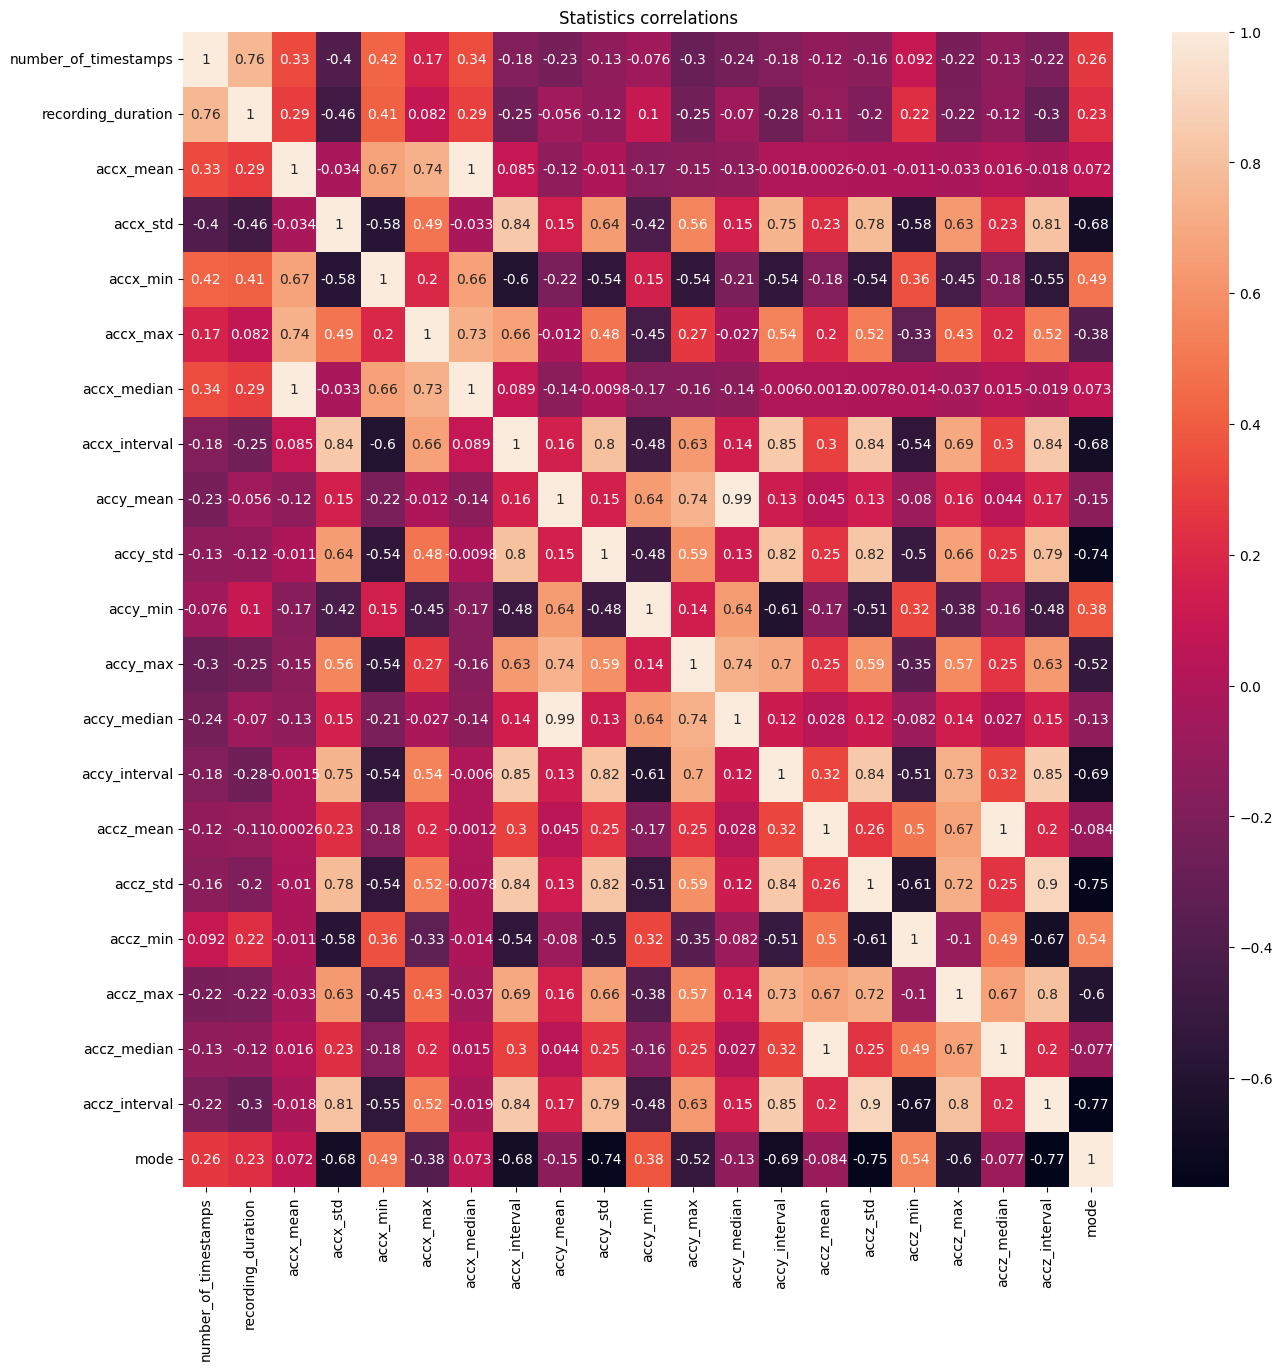

In [ ]:
import seaborn as sns

plt.figure(figsize=(15, 15))
corrs = stats_dataframe.corr()
sns.heatmap(corrs, annot=True)
plt.title("Statistics correlations")
plt.show()

לייצר את עמודת N

שהוגדרה במעבדה הקודמת

להכניס ממוצע, סטיית תקן, חציון, מינ, מקס וטווח שלה

ולהשתמש בה במודל

רעיון למודל: יקבל שורה שמייצגת את הדאטהפריים שמכילה את הסטטיסטיקות בתור פיצ'רים

בנוסף - צריך להשתמש גם במספר הצעדים (כרגע זורקים אותו)

## 2. Models selection, training and predictions

### 2.1 Classification model

### 2.2 Regression model